# Stereo SLAM

This is a major part of this project and will likely take some time. 

For stereo, feel free to look up existing tutorials that implement this and write your own code here. Do not spend too long tweaking parameters here, focus on getting decent results and move on. You can also use OpenCV functions to backproject to 3D. 

## PART 1: Stereo dense reconstruction

3-D point clouds are very useful in robotics for several tasks such as object detection, motion estimation (3D-3D matching or 3D-2D matching), SLAM, and other forms of scene understanding.  Stereo camerasprovide  us  with  a  convenient  way  to  generate  dense  point  clouds.Densehere,  in  contrast  tosparse,means all the image points are used for the reconstruction.  In this part of the assignment you will begenerating a dense 3D point cloud reconstruction of a scene from stereo images.

#### Procedure: 

<ol>
    <li> Generate a disparity map for each stereo pair.  Use OpenCV (e.g.  StereoSGBM) for this.  Notethat the images provided are already rectified and undistorted. </li>
    <li> Then, using the camera parameters and baseline information generate colored point clouds from each disparity map.  Some points will have invalid disparity values, so ignore them.  Use [Open3D]for storing your point clouds. </li>
    <li> Register (or transform) all the generated point clouds into your world frame by using the providedground truth poses. </li>
    <li> Visualize the registered point cloud data, in color.  Use Open3D for this </li>
</ol>
    
    
Write briefly about how the disparity map is generated (if you used SGBM, write about SGBM).

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:
#Getting the projections needed for each pose
posesfile = '../data/poses.txt'
poses = open(posesfile,'r')

pmats = []

for pmat in poses:
    pmatlist = pmat.split()
    pmatlist = [ float(x) for x in pmatlist ]
    pmatarray = np.array(pmatlist)
    pmatarray = np.reshape(pmatarray,(3,4))
    pmatarray = np.vstack((pmatarray,np.array([0,0,0,1])))
    pmats.append(pmatarray)

In [23]:
#loading all the images
leftdir = '../data/img2'
rightdir = '../data/img3'

#list of all image numbers
list_image_no = list(range(60,81))

#dictionary that given np array of image when given image number
leftdic = {}
rightdic = {}

for imagefile in os.listdir(leftdir):
    #getting image location
    imageloc = os.path.join(leftdir, imagefile)
    #image number
    imageno = int(imagefile[-6:-4])
    #image itself
    image = cv2.imread(imageloc)
    
    leftdic[imageno] = image
    
for imagefile in os.listdir(rightdir):
    #getting image location
    imageloc = os.path.join(rightdir, imagefile)
    #image number
    imageno = int(imagefile[-6:-4])
    #image itself
    image = cv2.imread(imageloc)
    
    rightdic[imageno] = image

In [165]:
# From file calib.txt
# K: 
# 7.070912e+02 0.000000e+00 6.018873e+02 0.000000e+00 7.070912e+02 1.831104e+02 0.000000e+00 0.000000e+00 1.000000e+00

# baseline:
# 0.53790448812 m

#from above information focus = f = K[0,0] = 7.070912e+02
#baseline = b = 0.53790448812

f = 7.070912e+02;
b = 0.53790448812;

In [177]:
#Q matrix
#https://answers.opencv.org/question/187734/derivation-for-perspective-transformation-matrix-q/

#finds disparity using SGBM
def find_disp(limg,rimg):
    window_size = 5
    min_disp = -50
    num_disp = 100
    stereo = cv2.StereoSGBM_create(minDisparity = min_disp, numDisparities = num_disp, blockSize=5,
        P1=8 * 3 * window_size ** 2,P2=32 * 3 * window_size ** 2)
    disparity = stereo.compute(limg, rimg).astype(np.float32)/ 64
    disparity = (disparity-min_disp)/num_disp
    return disparity

fpts = []
fcol = []

for i in list_image_no:
    #getting the colors
    colors = cv2.cvtColor(leftdic[i], cv2.COLOR_BGR2RGB)/255
    colors = colors[disparity!=None]
    
    disparity = find_disp(leftdic[i],rightdic[i])
    
    h,w = disparity.shape
    #note cy is +ve because of sign convention
    cx = -w/2
    cy = h/2
    
    Q = np.float32([[ 1,  0,  0, cx],
                    [ 0,  -1,  0, cy],
                    [ 0,  0,  0, f],
                    [ 0,  0,  1/b, 0]])

    #reproject to 3D
    curpcd = cv2.reprojectImageTo3D(disparity, Q)
    curpcd = curpcd.reshape((370* 1226, 3))
    curpcd = np.hstack((curpcd,np.ones((curpcd.shape[0],1))))
    
    for j in range(curpcd.shape[0]):
        #transform to baseframe
        projected = (pmats[i-60]@(curpcd[j].T))
        if(projected[3] <= 0):
            continue
        projected = projected[:3]/projected[3]
        fpts.append(projected)
        fcol.append(colors[j])


fpts = np.array(fpts)
fcol = np.array(fcol)


pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(fpts)
pcd.colors = o3d.utility.Vector3dVector(fcol)
o3d.visualization.draw_geometries([pcd])

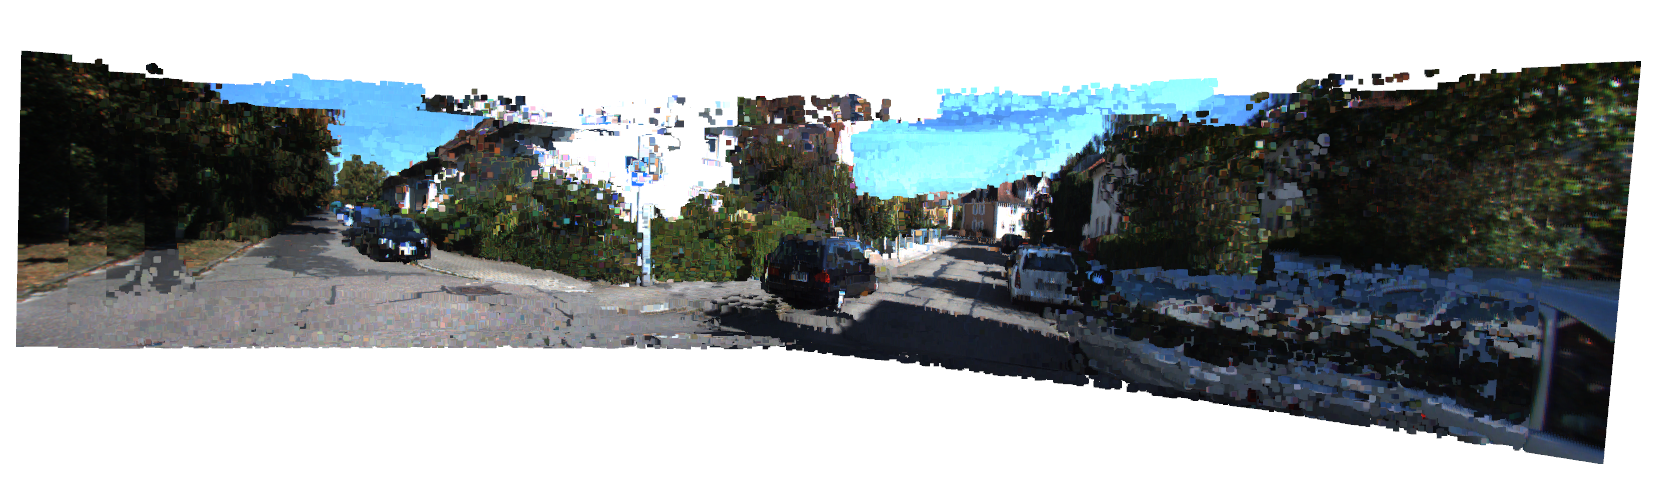

In [179]:
from IPython import display
display.Image("./reconstructed.png")

In [ ]:
##TODO SGMB EXPLANATION

## PART 2: Motion estimation using iterative PnP

Using the generated reconstruction from the previous part, synthesize a new image taken by a virtualmonocular camera fixed at any arbitrary position and orientation.  Your task in this part is to recoverthis pose using an iterative Perspective-from-n-Points (PnP) algorithm. 

#### Procedure: 

<ol>
    <li> Obtain a set of 2D-3D correspondences between the the image and the point cloud.  Since hereyou’re generating the image, this should be easy to obtain. </li>
    <li> For this set of correspondences compute the total reprojection error c= $\sum_{i} ‖x_i−P_{k}X_i‖^2 $    where $P_{k}= K[R_{k}|t_{k}]$, $X_{i}$ is the 3D point in the world frame, $x_{i}$ is its corresponding projection. </li>
    <li> Solve for the pose $T_{k}$ that minimizes this non-linear reprojection error using a Gauss-Newton (GN)scheme.  Recall that in GN we start with some initial estimated value $x_{o}$ and iteratively refine the estimate using $x_{1}$= $∆x+x_0$, where $∆x$ is obtained by solving the normal equations $J^{T}J∆x$= -$J^{T}e$, until convergence.The main steps in this scheme are computing the corresponding Jacobians and updating the estimates correctly.  For our problem,  use a 12×1 vector parameterization for $T_{k}$(the top 3×4submatrix).  Run the optimization for different choices of initialization and report your observations. </li>
</ol>

Make sure that you write about how you calculate the residual and jacobians. Do not just include the code. The pose that you have been given is the ground truth, so using that will obviously give good results for optimization, so try out something else as well.

In [496]:
import random

#We are allowed any arbritary position or orientation. So let us take the position of first pose given to us
Rt = np.linalg.inv(pmats[0])[:3,:] #inverse of pmat because we're going back to image
#Ground truth Projection Matrix
P = K @ Rt

#getting 500 3d points (world)
numpts = 500
indices = random.sample(range(0, fpts.shape[0]), numpts)
ptsW = fpts[indices]
ptsW = np.hstack((ptsW,np.ones((ptsW.shape[0],1))))


#going to 2d ie. image (camera)
ptsC = (P @ ptsW.T).T
ptsC = ptsC/ptsC[:,2].reshape((numpts,1))

#starting value of P that goes into Gauss-Newton
Po = np.copy(P)
#starting from something different from Ground truth but close enough so it doesn't get stuck
Po = Po + 10

In [497]:
#finds jacobian for a single world point
def findJacobian(ptW,Pgn):
    #image coordinates
    u,v,w = Pgn@ptW
    #given point coordinates
    x,y,z,k = ptW
    
    #making jacobian
    
    #making jacobian for x coordinate of image 
    #first row of P
    Jx1 = (1/w)*ptW
    #second row of P
    Jx2 = 0*ptW
    #third row of P
    Jx3 = (-u/(w**2))*ptW
    
    #making jacobian for y coordinate of image 
    #first row of P
    Jy1 = 0*ptW
    #second row of P
    Jy2 = (1/w)*ptW
    #third row of P
    Jy3 = (-v/(w**2))*ptW

    Jx = np.hstack((Jx1,Jx2,Jx3))
    Jy = np.hstack((Jy1,Jy2,Jy3))    
    
    J = np.vstack((Jx,Jy))
    
    
    return J

def findresidual(Pgn,ptsW,ptsC,numpts):
    #returns both the residual and the loss
    #our found ptsC using P
    ptsCcalc = (Pgn @ ptsW.T).T
    ptsCcalc = ptsCcalc/ptsCcalc[:,2].reshape((numpts,1))
    
    residual = (ptsCcalc - ptsC)[:,:2]
    loss = np.linalg.norm(residual)**2 #same as residual.T @ residual
    
    #reshaping into a single column
    residual = np.reshape(residual, (-1,1))
    
    return residual,loss

In [515]:
#initialise so that it's similar to P but not exactly P. This is so that it doesn't get stuck

Po = np.copy(P)
Po[0,1] = 0

#other intialisations
# Po = np.copy(P)
# Po[0,2] = 0

# Po = np.copy(P)
# Po[1,2] = 0


threshold = 1e-5
loss_history = []

while True:
    #Define J
    J = np.zeros((1,12)) #this row of zeros will be removed
    
    #get residual and loss
    residual,loss = findresidual(Po,ptsW,ptsC,numpts)
    
    print(f"loss : {loss}")
    
    #loss history
    loss_history.append(loss)
    
    #break if no change in loss
    if(len(loss_history)!=1 and abs(loss - loss_history[len(loss_history)-2]) < threshold):
        break
    
    
    #get jacobian
    for pt in ptsW:
        curj = findJacobian(pt,Po)
        J = np.vstack((J,curj))
    
    #removing the first row of zeros
    J = J[1:]
    
    #change in P using GN algo
    dP = (np.linalg.inv(J.T@ J) @ -(J.T @ residual))
    Po = Po + dP.reshape(3,4)

print("Optimised projection matrix using Gauss Newton is")
print(Po)

loss : 511733.2782097374
loss : 47442.57408432032
loss : 10422.247979585454
loss : 4404.870035486812
loss : 0.022324918628077783
loss : 0.004356922086349305
loss : 0.00016054933553272892
loss : 6.182581808551613e-05
loss : 0.0004992807187511717
loss : 9.30452653064206e-05
loss : 1.2019215713637916e-06
loss : 1.2602019276939605e-06
Optimised projection matrix using Gauss Newton is
[[-8.90623846e+02  5.38203181e+01 -2.56022069e+02 -1.53030871e+05]
 [-3.68038873e+01  7.13170573e+02 -1.52231966e+02  2.00118015e+01]
 [-4.11197034e-01  4.10600022e-02 -9.10244480e-01 -2.77784937e+01]]


In [516]:
#initialise so that it's similar to P but not exactly P. This is so that it doesn't get stuck


Po = np.copy(P)
Po[0,2] = 0

# Po = np.copy(P)
# Po[1,2] = 0


threshold = 1e-5
loss_history = []

while True:
    #Define J
    J = np.zeros((1,12)) #this row of zeros will be removed
    
    #get residual and loss
    residual,loss = findresidual(Po,ptsW,ptsC,numpts)
    
    print(f"loss : {loss}")
    
    #loss history
    loss_history.append(loss)
    
    #break if no change in loss
    if(len(loss_history)!=1 and abs(loss - loss_history[len(loss_history)-2]) < threshold):
        break
    
    
    #get jacobian
    for pt in ptsW:
        curj = findJacobian(pt,Po)
        J = np.vstack((J,curj))
    
    #removing the first row of zeros
    J = J[1:]
    
    #change in P using GN algo
    dP = (np.linalg.inv(J.T@ J) @ -(J.T @ residual))
    Po = Po + dP.reshape(3,4)

print("Optimised projection matrix using Gauss Newton is")
print(Po)

loss : 419381181.580403
loss : 2152272054.532461
loss : 240536.02824948815
loss : 3871.298003179719
loss : 2596.2589229070777
loss : 476.74237322684354
loss : 0.40032059732070063
loss : 0.016028221144495394
loss : 0.0005780780354377201
loss : 0.0001582618223360449
loss : 8.442681941900134e-07
loss : 3.816955144785882e-09
Optimised projection matrix using Gauss Newton is
[[-9.01523643e+02  5.44789673e+01 -2.59155358e+02 -1.54903724e+05]
 [-3.72542967e+01  7.21898620e+02 -1.54095076e+02  2.02386530e+01]
 [-4.16229424e-01  4.15625106e-02 -9.21384407e-01 -2.81184578e+01]]


In [517]:
#initialise so that it's similar to P but not exactly P. This is so that it doesn't get stuck


Po = np.copy(P)
Po[1,2] = 0


threshold = 1e-5
loss_history = []

while True:
    #Define J
    J = np.zeros((1,12)) #this row of zeros will be removed
    
    #get residual and loss
    residual,loss = findresidual(Po,ptsW,ptsC,numpts)
    
    print(f"loss : {loss}")
    
    #loss history
    loss_history.append(loss)
    
    #break if no change in loss
    if(len(loss_history)!=1 and abs(loss - loss_history[len(loss_history)-2]) < threshold):
        break
    
    
    #get jacobian
    for pt in ptsW:
        curj = findJacobian(pt,Po)
        J = np.vstack((J,curj))
    
    #removing the first row of zeros
    J = J[1:]
    
    #change in P using GN algo
    dP = (np.linalg.inv(J.T@ J) @ -(J.T @ residual))
    Po = Po + dP.reshape(3,4)

print("Optimised projection matrix using Gauss Newton is")
print(Po)

loss : 148274365.15639153
loss : 166771.7943996267
loss : 7157017.270444243
loss : 10285.911611450441
loss : 131.7980197877782
loss : 34358.96692945633
loss : 4616.100002024218
loss : 4440.104226626486
loss : 241.6715949741916
loss : 4.482299529113968
loss : 2.776521025063896
loss : 1.7957607688925035
loss : 168.02567470121625
loss : 131.0461224881276
loss : 114.80599449132991
loss : 1.3845546387597722
loss : 0.06737094488191774
loss : 193.9300208421106
loss : 340.02327677366947
loss : 23.772640311687375
loss : 0.37285687618347235
loss : 2.6036733280956015
loss : 2.191594825374611e-05
loss : 0.0003917850111787254
loss : 1.7696360069506055e-07
loss : 5.168348181076534e-07
Optimised projection matrix using Gauss Newton is
[[-8.90931045e+02  5.38388388e+01 -2.56110388e+02 -1.53083661e+05]
 [-3.68165649e+01  7.13416547e+02 -1.52284531e+02  1.99905518e+01]
 [-4.11338868e-01  4.10741650e-02 -9.10558451e-01 -2.77880754e+01]]


In [518]:
##TODO jacobian and report observations

## PART 3: Odometry Calculation

In part 1, you used the ground truth pose for registration. Here, try to estimate the pose using the RGB image data alone. 

#### Procedure:

1. This can be done by computing features across the two images and matching them. Since you already have the depth map, you now have correspondences between the depth maps of two images as well from the RGB feature matches. 
2. You can now convert this depth map to a point cloud.
3. Since you have correspondences between image points in the depth map, you have 3D correspondences here as well. Perform ICP here to get a good pose estimate.
4. Feed these initial pose estimates into the PnP pipeline and optimise further.